<img src="logo_UCLA_blue_boxed.svg" alt="ucla logo" width="150" align="left"/>

### **MAE 150A - Intermediate Fluid Mechanics**

<hr />

# Planar potential flows past stationary bodies

In this notebook, we'll take a look at how we can use distributions of singularities to generate potential flows past stationary obstacles.

### Set up the module

In [1]:
using MAE150A

In [2]:
using LinearAlgebra: diagm

In [3]:
pyplot()
initialize_environment()

This notebook will work with distributions of singularities. It will use some complex variables behind the scenes, and we need the help of a function for computing the dot product between two vectors expressed in complex form:

In [4]:
"""
    dotproduct(a,b)

Compute the dot product between `a` and `b`, each given as complex
forms of two-dimensional vectors.
"""
dotproduct(a::Number, b::Number) = real(conj(a)*b)

dotproduct

In [ ]:
function surface_velocity(targets,fs,sources,n̂,Δs)
    us = induce_velocity(targets, (fs,sources), 0)
    for (i,(ni,Δsi,source)) in enumerate(zip(n̂,Δs,sources))
        us[i] -= 0.5*im*source.S*ni/Δsi
    end
    return us
end

## Distributions of point vortices

Suppose we want to model a solid surface in a potential flow.
The only role of that surface is to prevent fluid from going through it.
We can accomplish the same thing by replacing the surface with a **distribution of singularities**. We place a large number of singularities (e.g., source, vortices, or doublets) on the surface of the body, and solve for their strengths such that the no-flow-through condition is enforced.

Mathematically, we would use an infinite number of singularities, each with vanishingly-small strength. But in practice, we can do very well by just using a large number, and then enforcing the no-flow-through condition at these points.

This forms a linear algebra problem: **find the strengths of $N$ singularities to enforce the no-flow-through condition at $N$ points.**

First, let us set up a free stream

In [6]:
U∞ = 1.0 + 0im
fs = Freestreams.Freestream(U∞)

PotentialFlow.Freestreams.Freestream(1.0 + 0.0im)

Now the velocity at any point in the fluid is equal to the freestream plus the velocity induced by each of the $N$ point vortices:

$$
\mathbf{u}(\mathbf{x}) = \mathbf{U}_\infty + \sum_{n = 1}^N \mathbf{u}_n(\mathbf{x})
$$

In this case, we use a slightly different means of enforcing the no-flow-through condition

$$
\sum_{n = 1}^N \mathbf{n}_i \cdot \mathbf{u}_n(\mathbf{x}_i) = - \mathbf{n}_i \cdot \mathbf{U}_\infty \qquad \text{for } i = 1, 2, \cdots, N.
$$

As long as the we are not evaluating the velocity that a segment induces on itself, we will treat the segment as a point source:

$$
    \mathbf{u}_n(\mathbf{x})
  = \frac{Q_n }{2\pi}
    \frac{\mathbf{x} - \mathbf{x}_n}
         {|\mathbf{x} - \mathbf{x}_n|^2} \qquad \text{when } \mathbf{x} \neq \mathbf{x}_n
$$

But how **would** we evaluate $\mathbf{u}_n(\mathbf{x}_n)$?  We probably won't go over it in class, so you'll just have to believe ([or not](#Or-Not)) that it is:

$$
\mathbf{n}_n \cdot \mathbf{u}_n(\mathbf{x}_n) = \frac{Q_n}{2\Delta s}
$$

<a id="back"></a>

So the no-flow-through condition above can be written in matrix form:

$$
\underbrace{
\begin{bmatrix}
\frac{1}{2\Delta s} & \mathbf{n}_1 \cdot \frac{1}{2\pi}\frac{\mathbf{x}_1 - \mathbf{x}_2}{|\mathbf{x}_1 - \mathbf{x}_2|^2}
& \cdots & \mathbf{n}_1 \cdot \frac{1}{2\pi}\frac{\mathbf{x}_1 - \mathbf{x}_N}{|\mathbf{x}_1 - \mathbf{x}_N|^2}
\\
\mathbf{n}_2 \cdot \frac{1}{2\pi}\frac{\mathbf{x}_2 - \mathbf{x}_1}{|\mathbf{x}_2 - \mathbf{x}_1|^2} & \frac{1}{2\Delta s}
& & \vdots
\\
\vdots & & \ddots & \vdots \\
\mathbf{n}_N \cdot \frac{1}{2\pi}\frac{\mathbf{x}_N - \mathbf{x}_1}{|\mathbf{x}_N - \mathbf{x}_1|^2} &
\cdots & \cdots &
\frac{1}{2\Delta s}
\end{bmatrix}}_{A}
\begin{bmatrix}
Q_1 \\
Q_2 \\
\vdots \\
\vdots \\
Q_n
\end{bmatrix} =
\underbrace{ -
\begin{bmatrix}
\mathbf{n}_1 \cdot \mathbf{U}_\infty \\
\mathbf{n}_2 \cdot \mathbf{U}_\infty \\
\vdots \\
\vdots \\
\mathbf{n}_N \cdot \mathbf{U}_\infty \\
\end{bmatrix}}_{b},
$$

which we can solve to find the strengths of the point sources.
In code, this will look something like:

#### Pressure distribution
Let's calculate the pressure distribution the surface of the object. We will need the fluid velocity on the surface for this. To calculate this, we simply evaluate it at all of the source locations. However, the source's effect on itself needs to be added in explicitly. Let's create a function to do that work for us.

In [66]:
function surface_velocity(targets,fs,sources,n̂,Δs)
    us = induce_velocity(targets, (fs,sources), 0)
    for (i,(ni,Δsi,source)) in enumerate(zip(n̂,Δs,sources))
        us[i] -= 0.5*im*source.S*ni/Δsi
    end
    return us
end

surface_velocity (generic function with 1 method)

Now, the pressure can be obtained by applying the Bernoulli equation between two points, one at a large distance away where we only have a uniform flow. The flow is steady and gravity is ignored here, so this is just

$$ p = p_\infty + \frac{1}{2}\rho U_\infty^2 - \frac{1}{2}\rho |\mathbf{u}|^2 $$ 

The **pressure coefficient** is defined as the difference of the pressure from the ambient pressure, normalized by the dynamic pressure in the uniform flow:

$$ C_p = \dfrac{p - p_\infty}{\frac{1}{2} \rho U_\infty^2} $$

Putting these two things together, the pressure coefficient is

$$ C_p = 1 - |\mathbf{u}|^2/U_\infty^2 $$

Remember that we are only interested here in the pressure at points on the surface, so $\mathbf{u}$ is the surface velocity. Let's compute the pressure coefficient here. We will plot it by coloring the source points with the local value of $C_p$.

In [ ]:
us = surface_velocity(targets,fs,sources,n̂,Δs)
Cp = 1 .- dotproduct.(us,us)/dotproduct(U∞,U∞)
plot(sources, marker_z = Cp, color = :RdBu_r, colorbar = :right, markersize = 10, title = "Cp distribution")

Before moving on, we'll wrap all of our steps into a function so we don't have to keep repeating ourselves.

In [249]:
# This function has default values for the starting points of the tracer particles and the integration time
# and time step size for the trajectory integration. You can override any of these, as examples below will show.

function simulate_flow(unit_vortices, Δs, n̂, U∞; tracer_start = collect(-3.0 .+ range(-3,3,length=31)*im), Tmax = 20.0, Δt = 0.01)

    fs = Freestreams.Freestream(U∞)
    
    b = -dotproduct.(im*n̂, U∞)

    targets = Elements.position.(unit_vortices)
    
    A = [dotproduct(im*n, induce_velocity(target, vortex, 0)) for (n, target) in zip(n̂, targets), vortex in unit_vortices]
    A .-= 0.5*diagm(0 => 1 ./ Δs)

    Γ = A \ b
    
    #Γtot = sum(Γ)
    #Γ .-= Γtot/length(n̂);
        
    vortices = Vortex.Point.(targets, Γ)
    
    us = surface_velocity(targets, fs, vortices, n̂, Δs)
    
    Cp = 1 .- dotproduct.(us,us)/dotproduct(U∞,U∞)
        
    tx, ty = compute_trajectories((fs,vortices),tracer_start,Tmax,Δt)
    
    plt = plot(tx, ty, color = colorant"black", xlabel = L"x", ylabel = L"y",
               xlim = (-3, 3), ylim = (-3, 3), size = (400, 400))
    plot!(plt, vortices, markersize = 2, color = :RdBu_r)
    
    plt, vortices, us, Cp, tx, ty
end

simulate_flow (generic function with 1 method)

### Flow Past a Cylinder

As before, we first construct the surface of the body with point sources:

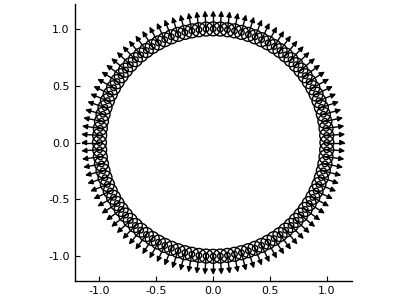

In [224]:
θ = range(0, 2π, length=101)[1:end-1]
Δs = fill(step(θ), length(θ))
vortices = Vortex.Point.(exp.(im.*θ), 1.0);
targets = Elements.position.(vortices)
n̂ = Elements.position.(vortices);

plot(vortices, ratio = 1)
quiver!(real.(targets), imag.(targets), quiver = 0.15.*(real.(n̂), imag.(n̂)), color = :black)
plot!(vortices, markersize = 10)

Now with a freestream from left to right, we have;

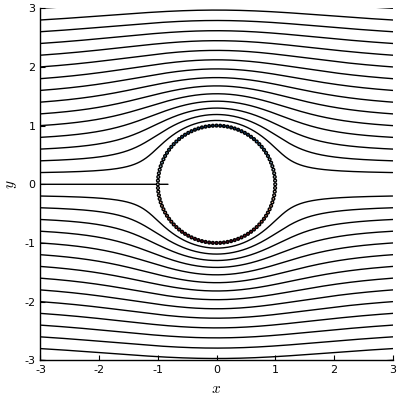

In [225]:
U∞ = 1.0+0im
plt, actual_vortices, us, Cp, tx, ty = simulate_flow(vortices, Δs, n̂, U∞)
plt

In [226]:
_, vel = self_induce_velocity((fs,actual_vortices),0)
dotproduct.(n̂,vel)

100-element Array{Float64,1}:
 0.02970297029703001 
 0.02964435827014615 
 0.02946875350438983 
 0.02917684903154546 
 0.0287697968652066  
 0.028249203454310798
 0.027617123343215685
 0.02687605106334698 
 0.026028911288430934
 0.025079047292139056
 0.024030207753711508
 0.022886531963637546
 0.021652533487764913
 ⋮                   
 0.021652533487767356
 0.022886531963634216
 0.024030207753714505
 0.025079047292138557
 0.026028911288427853
 0.02687605106334895 
 0.027617123343213312
 0.028249203454313546
 0.02876979686520703 
 0.029176849031544112
 0.029468753504390606
 0.02964435827014681 

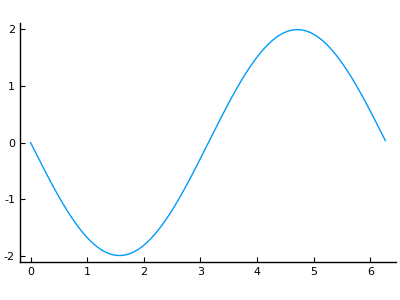

In [223]:
plot(θ,circulation.(actual_vortices)./Δs)

Let's compute the pressure distribution on the shape. 

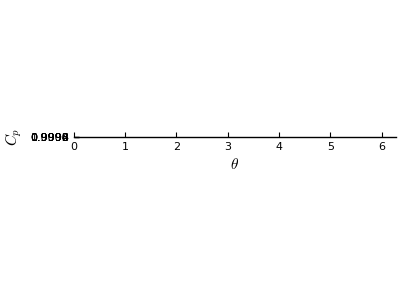

In [83]:
plot(θ,Cp,xlim=(0,2π),xlabel=L"\theta",ylabel=L"C_p")

Now with a downward freestream, this becomes:
(note that we need the tracers to start along the upper side of this region this time)

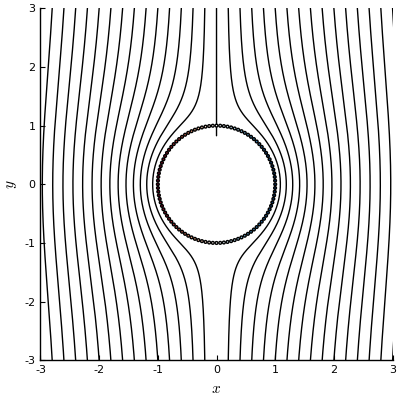

In [76]:
U∞ = -im
plt, actual_vortices, us, Cp, tx, ty = simulate_flow(vortices, Δs, n̂, U∞, tracer_start = collect(range(-3,3,length=31) .+ 3im))
plt

and the pressure, which is the same as the other case, but now shifted in angle by 90 degrees.

In [ ]:
plot(θ,Cp,xlim=(0,2π),xlabel=L"\theta",ylabel=L"C_p")

### Flow Past a Happy Face

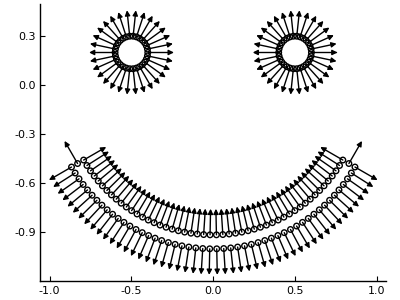

In [250]:
ns = 50
θ = range(π/6, 5π/6, length=ns)
Δs = step(θ)
targets = exp.(-im*θ)
n̂ = targets;
targets = vcat(targets, reverse((1 - 2Δs)*targets, 1))
n̂ = vcat(n̂, -reverse(n̂, 1))
#n̂[1] *= exp(im*π/4)
#n̂[ns] *= exp(-im*π/4)

dt = 0.5*[diff(targets);0]
dz = dt + circshift(dt,1) 
Δs = abs.(dz)

# add points on the ends of the smile
push!(targets,0.5*(targets[1]+targets[2ns]))
push!(Δs,2step(θ))
push!(n̂,n̂[1]*im)

push!(targets,0.5*(targets[ns]+targets[ns+1]))
push!(Δs,2step(θ))
push!(n̂,-n̂[ns]*im)    
        
θᵢ = range(0, 2π, length=31)[1:end-1]
left_eye = 0.1exp.(im*θᵢ) .- 0.5 .+ 0.2im
right_eye = 0.1exp.(im*θᵢ) .+ 0.5 .+ 0.2im;

append!(targets, left_eye)
append!(targets, right_eye)
append!(Δs, fill(0.5π/length(θᵢ), 2length(θᵢ)))
append!(n̂, exp.(im*θᵢ))
append!(n̂, exp.(im*θᵢ))

vortices = Vortex.Point.(targets, 1.0);
plot(vortices, ratio = 1)
quiver!(real.(targets), imag.(targets), quiver = 0.15.*(real.(n̂), imag.(n̂)), color = :black)

With $U_\infty$ going downward:

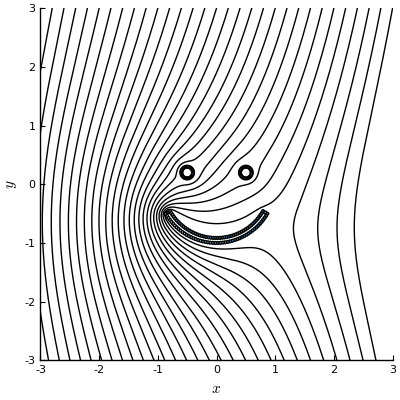

In [251]:
U∞ = 0.0-im
plt, actual_vortices, us, Cp, tx, ty = simulate_flow(vortices, Δs, n̂, U∞,tracer_start = collect(range(-3,3,length=31) .+ 3im),Δt = 0.0025)
plt

With $U_\infty$ going from left to right:

In [ ]:
U∞ = 1.0+0im
plt, actual_sources, us, Cp, tx, ty = simulate_flow(sources, Δs, n̂, U∞)
plt

## Appendix

### Or Not

We'll have to discuss source sheets for a little bit here to find out the velocity that the sheet induces on itself.
To keep it simple, we will use a straight sheet segment with length $\Delta s$ centered around the origin.
The equation describing this sheet segment is given by:

$$
\mathbf{u}_s(\mathbf{x}) = \frac{1}{2\pi}
\int_{-\Delta s/2}^{\Delta s/2}
\sigma(l) \frac{\mathbf{x} - \mathbf{x}_s(l)}
{|\mathbf{x} - \mathbf{x}_s(l)|}
\mathrm{d}l,
$$

where $\sigma$ is the local strength of the sheet.
This is not all that different from the point sources, except when you approach the sheet.

We first assume that $\Delta s$ is small enough that $\sigma$ is essentially constant in the interval.
Then, if we parametrize the target point as

$$
\mathbf{x} = r\cos\theta\,\mathbf{i} + r\sin\theta\,\mathbf{j},
$$

we obtain

$$
\begin{align*}
\mathbf{u}_s(\mathbf{x})
& = \frac{\sigma(0)}{2\pi}
\left[ \mathbf{i}
\int_{-\Delta s/2}^{\Delta s/2}
\frac{(r\cos\theta - l)}
{|\mathbf{x} - \mathbf{x}_s(l)|}
\mathrm{d}l + \mathbf{j}
\int_{-\Delta s/2}^{\Delta s/2}
\frac{r\cos\theta}
{|\mathbf{x} - \mathbf{x}_s(l)|}
\mathrm{d}l
\right] \\
& =-\frac{\sigma(0)}{2\pi}
\left( \frac{\mathbf{i}}{2}
\log\left[ (r\cos\theta - l)^2 + (r\sin\theta)^2
\right]_{-\Delta s/2}^{\Delta s/2} + \left. \mathbf{j}
\tan^{-1 }\left(\frac{r\cos\theta - l}
{r\sin\theta}
\right)
\right|_{-\Delta s/2}^{\Delta s/2}
\right)
\end{align*}
$$

As $\mathbf{x}$ approaches the origin, $r$ goes to zero

$$
\lim_{r \rightarrow 0}
\mathbf{u}_s(\mathbf{x}) = \mathrm{sign}(\theta)\frac{\sigma(0)}{2}.
$$

Since we are using point sources to model a segment of a source sheet, its strength $S$ is distributed along the segment, i.e.

$$
S = \int_{-\Delta s/2}^{\Delta s/2} \sigma(l) \mathrm{d}l.
$$

For a short sheet segment, we assume that $\sigma$ is essentially constant along the segment, so we have $\sigma \approx \frac{S}{\Delta s}$, which finally gives us

\begin{equation}
\lim_{r \rightarrow 0} \mathbf{u}_s(\mathbf{x}) = \frac{S}{2\Delta s}
\end{equation}

You can go [back](#back) now.